# Final Project: Audio Command Detection


### Group Members:
**Aida Ahmadi Parsa, Emelin Ghazarian, Zahra Latifi, Maryam Moghtaderi**

### Notes:
**We use 3-second-length mono-channel .wav files with a sample rate of 16KHz as dataset, and a small dataset. The dataset is manually recorded and is based on the audio data from different voices.**

**The final pieces of code (Part3) are also added to test the project using a real-time mirophone experiment.**

## Step 1:
We first import libraries we will need through the process.
Some of these libraries/packages include:
1. Tensorflow: Used for building and training our MLP Model
2. Seaborn: A proffesional matplotlib-based tool, for data visualization
3. pyaudio: Used to collect real-time data from microphone
4. librosa: A python package for music and audio analysis

In [1]:
#Import Libraries and packages
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
import librosa
import pyaudio
import sys

## Step 2:
We initialize the random number generator for Tensorflow and Numpy, in order to precieve reproducibilty

In [2]:
#Initialize the random number generator.
# Set the seed value for experiment reproducibility.
seed = 40
tf.random.set_seed(seed)
np.random.seed(seed)

## Step 3:
We have uploaded our dataset to a link as a .zip file, and we need to download and unzip it to the right directory.
This step is run ***only once*** and we will use the address to refer to the directory in next steps.

### Notes:
The dataset consists of 720 samples in .wav format (i.e. 105 samples for each of the four classes).
The recorded samples are converted into 16000Hz, mono-channel files using **FFmpeg** tool in cmd.

<span style="color:red">ATTENTION: DO NOT RUN THIS CELL MORE THAN ONCE:</span>

In [12]:
#Download .zip file and unzip it in data directory
DATASET_PATH = 'datasetdir2/dataset'
data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'dataset.zip',
      origin="https://s8.uupload.ir/filelink/fEWlM65qSHQh_dabdf91cd9/dataset_kij6.zip",
      extract=True,
      cache_dir='.', cache_subdir='datasetdir2')

## Step 4:
Each class's data samples are saved in a separate folder inside the .zip file. We can extract the name of the folders to build our **Commands** array, indicating the commands we will use in the project.

In [13]:
#Extracting command, using the names of folders in our data directory
file_path = 'C:\\Users\\Berooz Stock\\datasetdir3'
commands = np.array(tf.io.gfile.listdir(str(file_path)))

#Making sure the .zip file name is not counted as a command
commands = commands[(commands != 'dataset2.zip') & (commands !='.ipynb_checkpoints')]

#printing command array to be checked
print('Commands:', commands)

Commands: ['down' 'left' 'right' 'up']


## Step 5:
Now, we generate a TensorFlow dataset from audio files stored in our directory. 

We have used a batch size of 32, and each output sequence consists of 48000 bits, which is because we have 3 seconds of 16000Hz audio.

80% of total samples are used for training, and the rest are used for validation.

In [14]:
#Generate a TensorFlow dataset from audio files stored in the directory
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=file_path,
    batch_size=32,
    validation_split=0.2,
    seed=0,
    output_sequence_length=3*16000,
    subset='both')

#Extracting lable names based on our classes, and printing the lables array
label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 720 files belonging to 4 classes.
Using 576 files for training.
Using 144 files for validation.

label names: ['down' 'left' 'right' 'up']


## Step 6:

The purpose of the **squeeze** function is to remove the last dimension of the audio tensor, which has size 1 and is not needed for the subsequent processing. This can help reduce the memory footprint of the model and improve the training speed. Note that the squeeze function is applied using the map method, which applies a given function to each element of the dataset in parallel, making it an efficient way to preprocess large datasets.

In [15]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

#Applying to our dataset
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

#Getting an example from our samples
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(32, 48000)
(32,)


## Step 7:
In this step, we define a function that converts a waveform signal to its MFCCs:

In [41]:
def my_MFCC(waveform):
  batch_size, num_samples, sample_rate = 32, 48000, 16000.0
# A Tensor of [batch_size, num_samples] mono PCM samples in the range [-1, 1].
  pcm = waveform #tf.random.normal([batch_size, num_samples], dtype=tf.float32)

# A 1024-point STFT with frames of 64 ms and 75% overlap.
  stfts = tf.signal.stft(pcm, frame_length=1024, frame_step=256,
                       fft_length=1024)
  spectrograms = tf.abs(stfts)

# Warp the linear scale spectrograms into the mel-scale.
  num_spectrogram_bins = stfts.shape[-1]
  lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 7600.0, 80
  linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
      num_mel_bins, num_spectrogram_bins, sample_rate, lower_edge_hertz,
      upper_edge_hertz)
  mel_spectrograms = tf.tensordot(spectrograms, linear_to_mel_weight_matrix, 1)
  mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(
      linear_to_mel_weight_matrix.shape[-1:]))

# Compute a stabilized log to get log-magnitude mel-scale spectrograms
  log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

# Compute MFCCs from log_mel_spectrograms and take the first 13
  mfccs = tf.signal.mfccs_from_log_mel_spectrograms(
      log_mel_spectrograms)[..., :13]
  # tmp = mfccs.shape
  # out = tf.reshape(mfccs,[tmp[1]*tmp[2]])
  return(mfccs)


## Step 8: Checkpoint!
<span style="color:Blue">Let's check out some of the audio samples and their corresponding waveform and MFCC shapes!</span>

In [17]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  MFCC = my_MFCC(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('MFCC shape:', MFCC.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: right
Waveform shape: (48000,)
MFCC shape: (184, 13)
Audio playback


Label: right
Waveform shape: (48000,)
MFCC shape: (184, 13)
Audio playback


Label: up
Waveform shape: (48000,)
MFCC shape: (184, 13)
Audio playback


## Step 9:
We define a function which takes a dataset ds as input and applies a mapping function to each element of the dataset using the map function. The mapping function takes an audio waveform and a label as input, and returns a tuple of the MFCCs and label.

In [18]:
def make_MFCC_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (my_MFCC(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

## Step 10:
Now we use the above function to create our MFCC datasets for training and validation

In [19]:
#creating new datasets with MFCCs
train_features_ds = make_MFCC_ds(train_ds)
val_features_ds = make_MFCC_ds(val_ds)
test_features_ds = make_MFCC_ds(test_ds)
for example_MFCCs, example_spect_labels in train_features_ds.take(1):
 break

## Part 2: Training The MLP Model

## Step 1:
We now perform caching, shuffling, and prefetching on the MFCC datasets created earlier:

1. The cache function is called on the train_features_ds and val_features_ds datasets. This caches the elements of the dataset in memory or on disk (depending on available resources) after they are loaded for the first time. This can improve the performance of the dataset by avoiding the need to load the data from disk or compute the spectrograms again for each epoch.

2. The shuffle function is called on the train_features_ds dataset with a buffer size of 500. This shuffles the elements of the dataset randomly, with a buffer size of 500 elements used for the shuffling process. This can help to randomize the order of the elements and avoid overfitting to the order of the data.

3. The prefetch function is called on both the train_features_ds and val_features_ds datasets with the tf.data.AUTOTUNE argument. This prefetches elements from the dataset in the background while the model is training, allowing the data to be loaded more efficiently and reducing the time spent waiting for data to become available. The tf.data.AUTOTUNE argument allows TensorFlow to automatically determine the optimal number of elements to prefetch based on available computational resources.

In [36]:
train_features_ds = train_features_ds.cache().shuffle(500).prefetch(tf.data.AUTOTUNE)
val_features_ds = val_features_ds.cache().prefetch(tf.data.AUTOTUNE)
test_features_ds = test_features_ds.cache().prefetch(tf.data.AUTOTUNE)

## step 2:
Here comes the tricky part, which we build a sequential model for our MLP, using Tensorflow's Keras API!

As the dataset is not too large, making a very complex model would potentially result in overfitting. So, we try to keep our model as simple as possible. Note that the Dropout layers are also used to reduce the chance of overfitting.


In [37]:
#Getting the shape of the input spectrograms
input_shape = example_MFCCs.shape[1:]
# input_shape = (186, 13)
print('Input shape:', input_shape)

#Getting the number of labels
num_labels = len(label_names)

# Instantiating the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()

# Fitting the state of the layer to the spectrograms with `Normalization.adapt`.
norm_layer.adapt(data=train_features_ds.map(map_func=lambda spec, label: spec))

#Adding the desired layers to our model
model = models.Sequential([
    layers.Input(shape=input_shape),
#     norm_layer,
    layers.Flatten(),
    layers.Dense(1000, activation='relu'),
#     layers.Dense(100, activation='relu'),
#     layers.BatchNormalization(synchronized=True),
#     layers.Dropout(0.2),
    layers.Dense(500, activation='relu'),
    #layers.BatchNormalization(),
#     layers.Dropout(0.2),
#     layers.Dense(100, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_labels, activation = 'softmax'),
#     layers.Dense(num_labels),

])

# Printing out the summary of the created model
model.summary()

Input shape: (184, 13)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 2392)              0         
                                                                 
 dense_9 (Dense)             (None, 1000)              2393000   
                                                                 
 dense_10 (Dense)            (None, 500)               500500    
                                                                 
 dropout_3 (Dropout)         (None, 500)               0         
                                                                 
 dense_11 (Dense)            (None, 4)                 2004      
                                                                 
Total params: 2,895,504
Trainable params: 2,895,504
Non-trainable params: 0
_________________________________________________________________


## Step 3:
We compile the created model, using Adam optimizer.

In [38]:
#Compiling model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

# Step 4:
We define 45 epochs to fit our model with, using previously created datasets for validateion and training.

**Note:**
Also, we have disabled early stopping so that the epochs will be completed.

In [39]:
#Defining number of epochs to be worked on
EPOCHS = 45

#Model fitting step
history = model.fit(
    train_features_ds,
    validation_data=val_features_ds,
    epochs=EPOCHS
#     ,callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)


Epoch 1/45
18/18 [==============================] - 2s 65ms/step - loss: 16.8426 - accuracy: 0.2674 - val_loss: 5.3881 - val_accuracy: 0.2031
Epoch 2/45
18/18 [==============================] - 1s 46ms/step - loss: 3.7430 - accuracy: 0.3351 - val_loss: 1.5642 - val_accuracy: 0.4375
Epoch 3/45
18/18 [==============================] - 1s 46ms/step - loss: 1.6334 - accuracy: 0.4306 - val_loss: 1.2149 - val_accuracy: 0.5000
Epoch 4/45
18/18 [==============================] - 1s 47ms/step - loss: 1.0831 - accuracy: 0.5486 - val_loss: 1.2166 - val_accuracy: 0.4688
Epoch 5/45
18/18 [==============================] - 1s 48ms/step - loss: 0.9701 - accuracy: 0.6042 - val_loss: 0.9811 - val_accuracy: 0.6875
Epoch 6/45
18/18 [==============================] - 1s 50ms/step - loss: 0.8175 - accuracy: 0.6736 - val_loss: 1.0059 - val_accuracy: 0.6719
Epoch 7/45
18/18 [==============================] - 1s 50ms/step - loss: 0.7299 - accuracy: 0.7031 - val_loss: 0.7946 - val_accuracy: 0.6719
Epoch 8/45
1

## Step 5:
Here we plot Training/Validation accuracy and loss, as a function of epochs. The accuracy must increase over the number of epochs while the loss must be decreased.

Text(0, 0.5, 'Accuracy [%]')

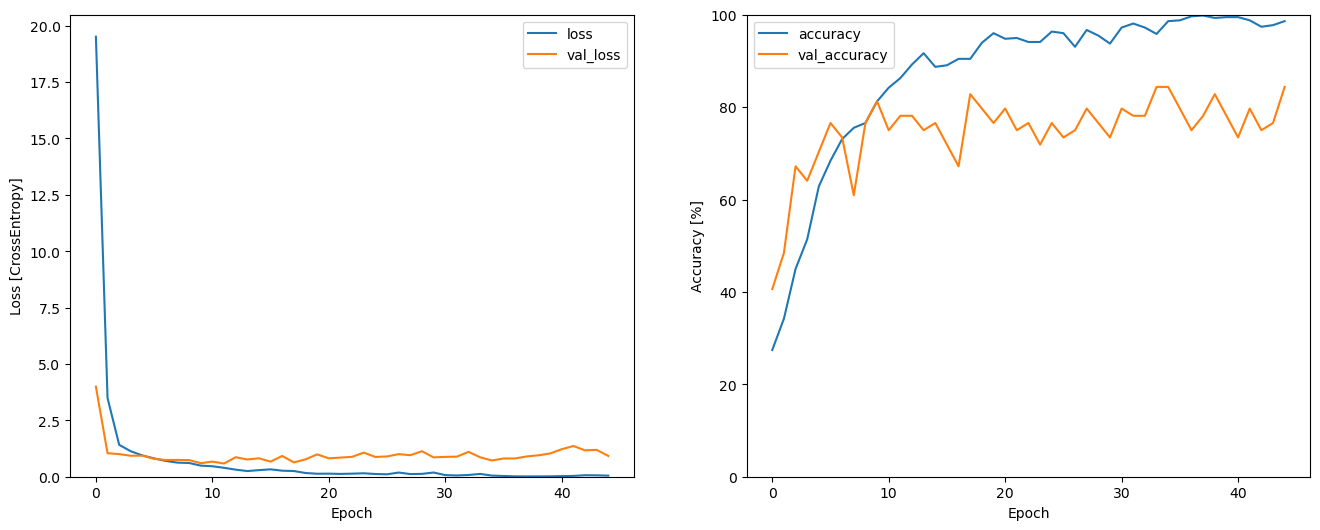

In [196]:
#Plotting Loss values for training and validation
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

#Plotting Accuracy values for training and validation
plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Step 6: Checkpoint!
<span style="color:Blue">Let's check out the prediction results for an audio sample, which does not exist in our dataset!</span>

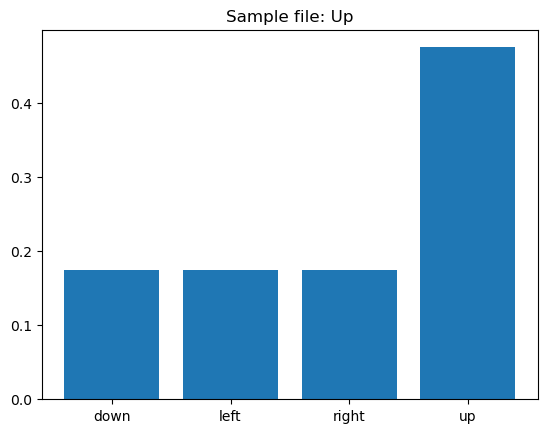

tf.Tensor([[2.0566273e-05 4.1665931e-08 6.5343993e-06 9.9997294e-01]], shape=(1, 4), dtype=float32)


In [43]:
#Reading the test file and decode it using the desired lengths and sample rate, and number of channels
x = tf.io.read_file('msg-1840141157-39.wav')
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=3*16000)
#Squeezing to remove the extra axis
x = tf.squeeze(x, axis=-1)
waveform = x
#Getting the MFCC from waveform
x = my_MFCC(x)
x = x[tf.newaxis,...]

#Predict the command, using our trained model
prediction = model(x)

#Plotting the results as a bar chart
x_labels = ['down', 'left', 'right', 'up']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Sample file: Up')
plt.show()

#Displaying the original test sample, and the value of the predictions for each command label
display.display(display.Audio(waveform, rate=16000))
print(prediction)

## Step 7:
We evaluate the accuracy of the model, using our test data

In [198]:
model.evaluate(test_features_ds, return_dict=True)

3/3 [==============================] - 1s 8ms/step - loss: 1.1200 - accuracy: 0.7500


{'loss': 1.1200101375579834, 'accuracy': 0.75}

## Step 8:
Finally, we save the model to be used later. We can also export the directory of the saved model as a .zip file, to be later used outside the jupyter notebook.

In [44]:
model.save('saved_model_final')

INFO:tensorflow:Assets written to: saved_model_final\assets


INFO:tensorflow:Assets written to: saved_model_final\assets


## Part 3: Real-Time Command Recognition

## Step 1:
We define a function for preprocessing, which includes 3 steps:
1. The input waveform is first normalized to have values between -1 and 1 by dividing it by 32768.
2. The waveform is then converted to a TensorFlow tensor with a float32 data type.
3. The get_spectrogram function is called with the waveform as input to compute the spectrogram.
4. The resulting spectrogram tensor is then expanded with an additional dimension at the beginning to obtain a tensor of shape (1, height, width, channels).
5. Finally, the spectrogram tensor is returned as the output of the function.

In [45]:
def preprocess_audiobuffer(waveform):
    """
    waveform: ndarray of size (48000, )

    output: Spectogram Tensor of size: (1, `height`, `width`, `channels`)
    """
    #  normalizing from [-32768, 32767] to [-1, 1]
    waveform =  waveform / 32768

    #Converting the raw waveform to a tensor
    waveform = tf.convert_to_tensor(waveform, dtype=tf.float32)

    #Getting the spectogram from the waveform
    mfcc = my_MFCC(waveform)

    # adding one dimension
    mfcc = tf.expand_dims(mfcc, 0)

    return mfcc

## Step 2:
This function is defined to be used to record audio from a microphone and retrieve the recorded audio as a NumPy array for further processing and analysis.

In [46]:
#Defining the size of buffer, channels, sampling rate and format
FRAMES_PER_BUFFER = 3200
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 16000
p = pyaudio.PyAudio()

def record_audio():
    stream = p.open(
        format=FORMAT,
        channels=CHANNELS,
        rate=RATE,
        input=True,
        frames_per_buffer=FRAMES_PER_BUFFER
    )

    #print("start recording...")

    frames = []
    seconds = 3
    #Reading data from stream for 3 seconds
    for i in range(0, int(RATE / FRAMES_PER_BUFFER * seconds)):
        data = stream.read(FRAMES_PER_BUFFER)
        frames.append(data)

    #print("recording stopped")

    #Stopping the stream and closing it
    stream.stop_stream()
    stream.close()

    return np.frombuffer(b''.join(frames), dtype=np.int16)


def terminate():
    p.terminate()

## Step 3:
We use our trained model to the predict the command captured by the microphone. Then, we check the maximum predicted value and decide to do not do anything if this max value is lower than a certain threshold. However if the max predicted value is large and reliable enough, we print out the detected command label.

In [49]:
loaded_model = models.load_model("saved_model_final")

def predict_mic():
    #Getting Data from microphone, and preprocess it
    audio = record_audio()
    spec = preprocess_audiobuffer(audio)

    #Making the prediction, using our trained model
    prediction = loaded_model(spec)
    #print(prediction)

    #Checking if the prediction is reliable enough
    if np.max(prediction) > 0.9:
        label_pred = np.argmax(prediction, axis=1)
        #Printing the predicted command
        command = commands[label_pred[0]]
        print("Predicted label:", command)
    else:
        command = 0
    return command

## Step 4: The Final Experiment!

In [50]:
if __name__ == "__main__":
    try:
        while True:
            command = predict_mic()
    except KeyboardInterrupt:
        print('Interrupted')

Predicted label: down
Predicted label: down
Predicted label: left
Predicted label: down
Predicted label: down
Predicted label: down
Predicted label: down
Predicted label: left
Predicted label: right
Predicted label: right
Predicted label: right
Predicted label: down
Interrupted
